# Import required libraries

In [1]:
import torch
torch.set_float32_matmul_precision('high')  # Tăng hiệu năng
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import h5py
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import warnings
import copy
import pickle

from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
torchvision.__version__

'0.21.0+cu124'

# GETTING DATASET

In [4]:
# 1) Load bộ H5 như cũ
def load_h5_dataset():
    train_dataset = h5py.File('/kaggle/input/restures/train_signs.h5',"r")
    X_train = np.array(train_dataset["train_set_x"])
    y_train = np.array(train_dataset["train_set_y"],dtype='int')

    test_dataset = h5py.File('/kaggle/input/restures/test_signs.h5', "r")
    X_test = np.array(test_dataset["test_set_x"])
    y_test = np.array(test_dataset["test_set_y"],dtype='int')

    classes = np.array(test_dataset["list_classes"])
    return X_train, y_train, X_test, y_test, classes

X_train_h5, y_train_h5, X_test_h5, y_test_h5, classes = load_h5_dataset()
print("H5 X_train:", X_train_h5.shape, "X_test:", X_test_h5.shape)

target_h, target_w = X_train_h5.shape[1], X_train_h5.shape[2]

def load_folder_dataset_all(root_dir, target_size):
    root_dir = Path(root_dir)
    assert root_dir.exists(), f"Không tìm thấy folder: {root_dir}"

    class_dirs = sorted([d for d in root_dir.iterdir() if d.is_dir()],
                        key=lambda x: x.name)
    class_names = [d.name for d in class_dirs]

    class_to_idx = {name: int(name) for name in class_names}
    print("Folder classes:", class_names)
    print("class_to_idx:", class_to_idx)

    th, tw = target_size
    images = []
    labels = []

    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.png"]
    for cls_name in class_names:
        cls_dir = root_dir / cls_name
        for ext in exts:
            for img_path in cls_dir.glob(ext):
                img = cv2.imread(str(img_path))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (tw, th))             # resize về cùng kích thước H5
                images.append(img)
                labels.append(class_to_idx[cls_name])

    images = np.array(images, dtype=X_train_h5.dtype)
    labels = np.array(labels, dtype='int')

    print("Tổng ảnh folder:", images.shape[0])
    print("Folder image shape sau resize:", images.shape[1:])
    return images, labels

X_folder_all, y_folder_all = load_folder_dataset_all(
    "/kaggle/input/hand-dataset-friends-ver2/hand-dataset-ver2",
    target_size=(target_h, target_w)
)
print("Folder total:", X_folder_all.shape, y_folder_all.shape)

# Gộp H5 (train + test) + folder lại
X_h5_all = np.concatenate([X_train_h5, X_test_h5], axis=0)
y_h5_all = np.concatenate([y_train_h5, y_test_h5], axis=0)
print("H5 total:", X_h5_all.shape, y_h5_all.shape)

X_all = np.concatenate([X_h5_all, X_folder_all], axis=0)
y_all = np.concatenate([y_h5_all, y_folder_all], axis=0)
print("ALL merged:", X_all.shape, y_all.shape)

# Chia lại 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=42
)

NUM_CLASSES = len(classes)
print('X_train:', X_train.shape, type(X_train))
print('y_train:', y_train.shape, type(y_train))
print('X_test:', X_test.shape, type(X_test))
print('y_test:', y_test.shape, type(y_test))
print('classes:', classes.shape, type(classes))

H5 X_train: (1080, 64, 64, 3) X_test: (120, 64, 64, 3)
Folder classes: ['0', '1', '2', '3', '4', '5']
class_to_idx: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Tổng ảnh folder: 823
Folder image shape sau resize: (64, 64, 3)
Folder total: (823, 64, 64, 3) (823,)
H5 total: (1200, 64, 64, 3) (1200,)
ALL merged: (2023, 64, 64, 3) (2023,)
X_train: (1618, 64, 64, 3) <class 'numpy.ndarray'>
y_train: (1618,) <class 'numpy.ndarray'>
X_test: (405, 64, 64, 3) <class 'numpy.ndarray'>
y_test: (405,) <class 'numpy.ndarray'>
classes: (6,) <class 'numpy.ndarray'>


In [5]:
train_ds = []
for i in range(len(X_train)):
    record = {
        'image': X_train[i],
        'label': y_train[i]
    }
    train_ds.append(record)

test_ds = []
for i in range(len(X_test)):
    record = {
        'image': X_test[i],
        'label': y_test[i]
    }
    test_ds.append(record)

print('train_ds:', train_ds[0].keys(), len(train_ds), type(train_ds))
print('test_ds:', test_ds[0].keys(), len(test_ds), type(test_ds))

train_ds: dict_keys(['image', 'label']) 1618 <class 'list'>
test_ds: dict_keys(['image', 'label']) 405 <class 'list'>


In [6]:
y_train_labels = sorted(dict(Counter(y_train)).items())
print('y_train_labels:', y_train_labels)
y_test_labels = sorted(dict(Counter(y_test)).items())
print('y_test_labels:', y_test_labels)

y_train_labels: [(0, 264), (1, 265), (2, 306), (3, 283), (4, 260), (5, 240)]
y_test_labels: [(0, 66), (1, 66), (2, 77), (3, 71), (4, 65), (5, 60)]


# Setting the Hyperparameters

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-3
IMAGE_SIZE = 224
CHANNELS = 3
DROP_RATE = 0.5
NUM_WORKERS = 4


In [8]:
import multiprocessing
num_workers = min(4, multiprocessing.cpu_count())
print('num_workers:', num_workers)

num_workers: 4


# Vẽ ảnh gốc

In [9]:
def plot_images_grid(dataset, labels, n=10):
    rows = len(labels)
    plt.figure(figsize=(n * 2, rows * 2))

    for row, label in enumerate(labels):
        images = [record['image'] for record in dataset if record['label'] == label]
        count = min(len(images), n)

        for i in range(count):
            idx = row * n + i + 1
            plt.subplot(rows, n, idx)
            plt.imshow(images[i])
            plt.axis('off')
            plt.title(f"Label {label}", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_images_grid(train_ds, labels=[0, 1, 2, 3, 4, 5], n=6)

# Transformations and Dataloader

In [10]:
class RestureDataset(Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        record = self.dataset[idx]
        image = record['image']
        label = record['label']

        if self.transforms:
            image = self.transforms(image)

        return {'image': image, 'label': label}

In [11]:
# Chuẩn hóa ImageNet cho ResNet18
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [12]:
train_dataset = RestureDataset(train_ds, train_transform)
test_dataset  = RestureDataset(test_ds,  test_transform)

print('train_dataset:', len(train_dataset))
print('test_dataset:', len(test_dataset))

train_dataset: 1618
test_dataset: 405


In [13]:
print("Một sample:", train_dataset[0]['image'].shape)

Một sample: torch.Size([3, 224, 224])


In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=True)

print('Length of train loader:', len(train_loader.dataset), '=', len(train_loader), '*', BATCH_SIZE)
print('Length of test loader:', len(test_loader.dataset), '=', len(test_loader), '*', BATCH_SIZE)


Length of train loader: 1618 = 51 * 32
Length of test loader: 405 = 13 * 32


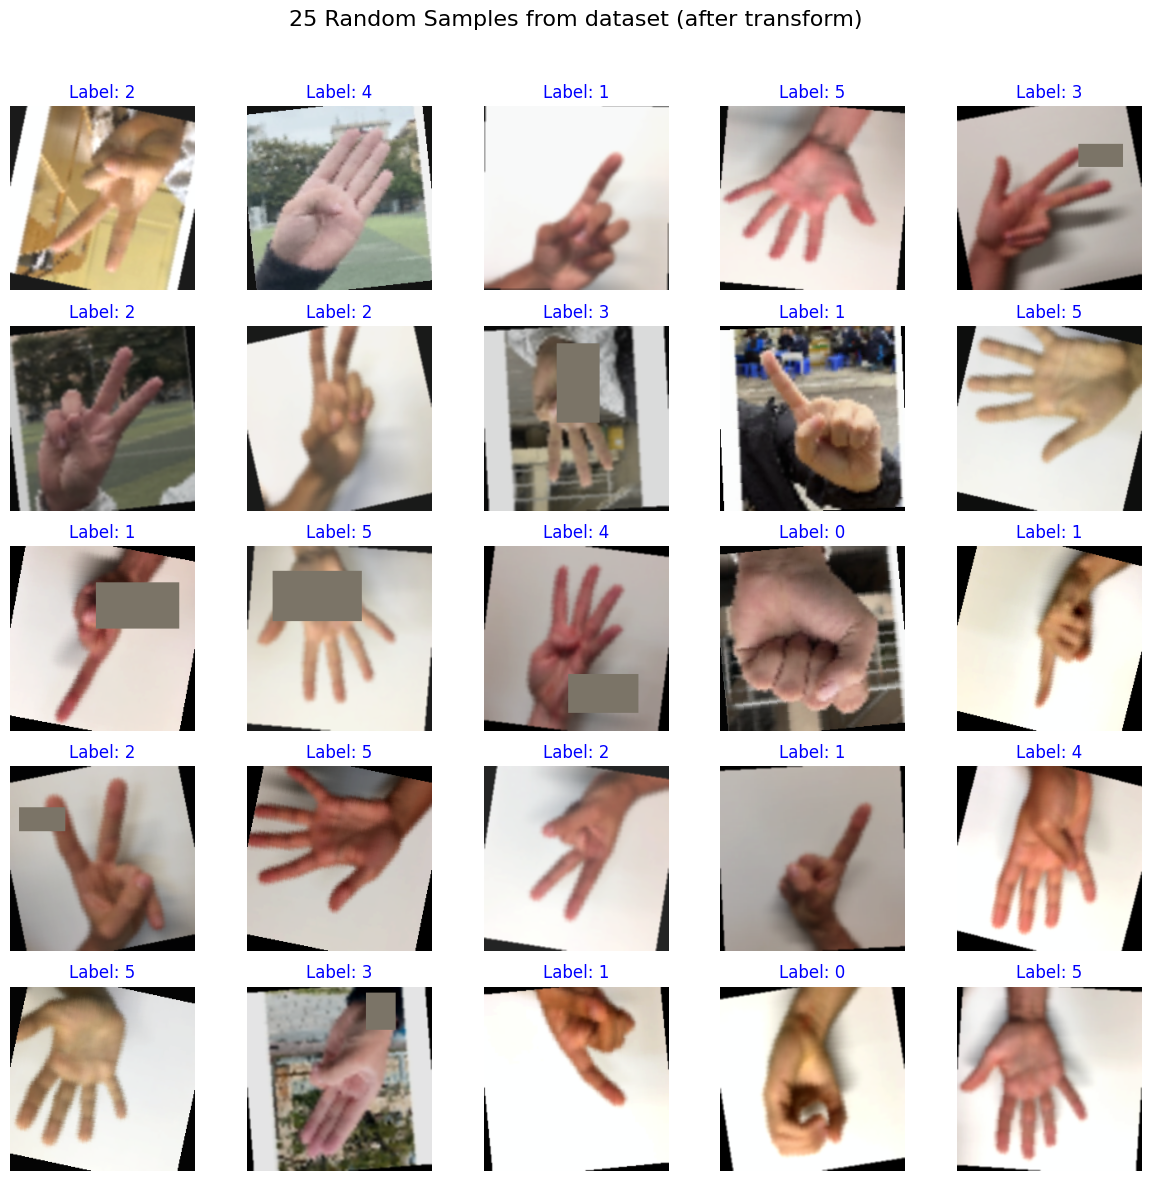

In [15]:
# vẽ 25 ảnh sau augment
num_images = 25
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle("25 Random Samples from dataset (after transform)", fontsize=16)

indices = random.sample(range(len(train_dataset)), num_images)
for i, ax in enumerate(axes.flat):
    item = train_dataset[indices[i]]
    image = item['image']
    label = item['label']

    img = image.permute(1, 2, 0).numpy()
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {label}', fontsize=12, color='blue')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Setup device - agnostic code

In [16]:
!nvidia-smi

Mon Nov 17 09:44:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


# Biểu đồ nhãn dữ liệu

In [18]:
classes

array([0, 1, 2, 3, 4, 5])

In [19]:
import seaborn as sns

def plot_label_distribution(dataset, title='Phân phối nhãn dữ liệu'):
    labels = [label['label'] for label in dataset]
    class_names = [f'Class {i}' for i in sorted(set(labels))]

    label_counts = Counter(labels)
    counts = [label_counts[i] for i in range(len(class_names))]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=class_names, y=counts, hue=class_names, palette='Set2')

    for i, count in enumerate(counts):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

    plt.title(title)
    plt.xlabel('Lớp')
    plt.ylabel('Số lượng mẫu')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

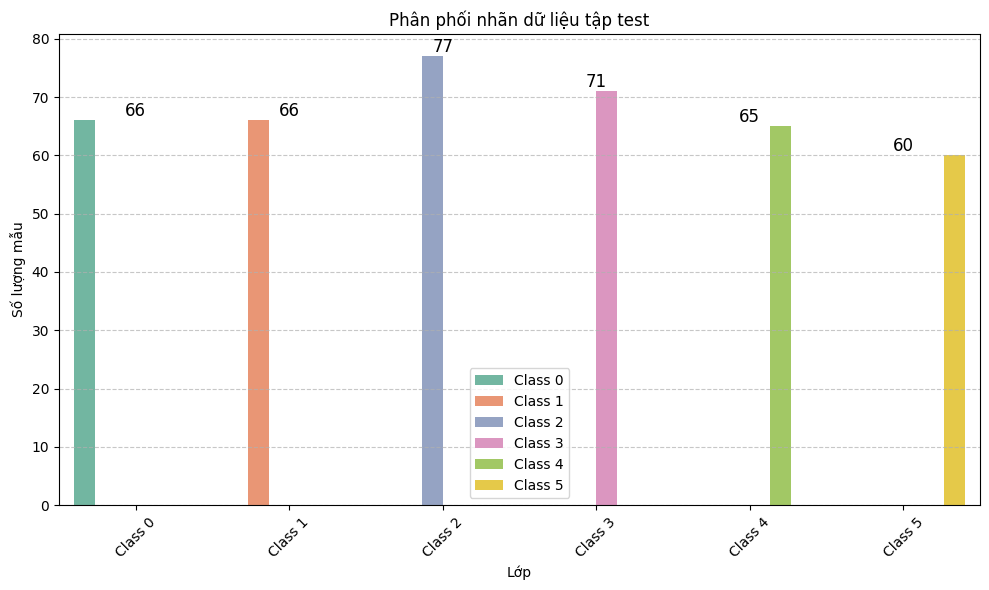

In [20]:
plot_label_distribution(train_dataset.dataset, title='Phân phối nhãn dữ liệu tập train')
plot_label_distribution(test_dataset.dataset, title='Phân phối nhãn dữ liệu tập test')

# Define architecture for model

In [21]:
from torchvision.models import resnet18

input_sample = None
for item in train_loader:
    input_sample = item['image']
    break
print('input_sample:', input_sample.shape)

input_sample: torch.Size([32, 3, 224, 224])


In [22]:
def build_resnet18(num_classes, freeze_backbone=True):
    try:
        from torchvision.models import ResNet18_Weights
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)
        print("Dùng ResNet18 pretrained (IMAGENET1K_V1)")
    except Exception as e:
        print("Không dùng được ResNet18_Weights, fallback pretrained=True:", e)
        model = resnet18(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if freeze_backbone:
        for name, p in model.named_parameters():
            p.requires_grad = False
        for name, p in model.fc.named_parameters():
            p.requires_grad = True
        print("🔥 Phase 1: Freeze backbone, chỉ train fc")

    return model

In [23]:
model = build_resnet18(NUM_CLASSES, freeze_backbone=True)
model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Dùng ResNet18 pretrained (IMAGENET1K_V1)
🔥 Phase 1: Freeze backbone, chỉ train fc
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, moment

In [24]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num trainable params (Phase 1):', num_params)

Num trainable params (Phase 1): 3078


# Defining Loss function and Optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
print('Loss function:', criterion)



Loss function: CrossEntropyLoss()


# Train model

In [26]:
for item in train_loader:
    print(item['image'].shape, len(item['image']))
    print(item['label'].shape, len(item['label']))
    break

torch.Size([32, 3, 224, 224]) 32
torch.Size([32]) 32


In [27]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0,
                 model_name='model', dataset_name='dataset'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.dir_path = Path(f"{self.model_name}_{self.dataset_name}_model")
        self.dir_path.mkdir(parents=True, exist_ok=True)
        self.save_model_path = None
        self.counter = 0
        self.best_score = None
        self.best_model = None
        self.min_score = None
        self.min_model = None
        self.min_path = None
        self.early_stop = False
        self.checkpoint_path = ''

    def __call__(self, val_loss, model, file_name):
        score = val_loss
        self.save_model_path = self.dir_path / file_name

        if self.min_score is None and self.min_model is None:
            self.min_score = score
            self.min_model = model
            self.min_path = self.save_model_path
            self.checkpoint_path = file_name.replace(".pth", "")

        if self.best_score is None or score < self.best_score + self.delta:
            if self.verbose:
                print(f'[EarlyStopping] 🎯 Cải thiện val_loss: {self.best_score} → {score:.4f}')
            self.best_score = score
            self.best_model = copy.deepcopy(model)
            self.counter = 0
            if self.best_score < self.min_score:
                self.min_score = self.best_score
                self.min_model = copy.deepcopy(self.best_model)
                self.min_path = self.save_model_path
                self.checkpoint_path = file_name.replace(".pth", "")
        else:
            self.counter += 1
            if self.verbose:
                print(f'[EarlyStopping] ⏳ Không cải thiện {self.counter}/{self.patience} lần.')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self):
        if self.min_model and self.min_path:
            torch.save(self.min_model.state_dict(), self.min_path)
            if self.verbose:
                print(f'[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: {self.min_path}')


def fit(model, train_loader, valid_loader, optimizer, criterion,
        epochs, device, model_name='model', dataset_name='dataset', patience=5):
    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []

    early_stopping = EarlyStopping(patience=patience, verbose=True,
                                   model_name=model_name, dataset_name=dataset_name)

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        train_loss, train_correct = 0, 0
        train_bar = tqdm(train_loader, desc=f"[Epoch {epoch}/{epochs}] Training", leave=False)
        for item in train_bar:
            x = item['image'].to(device)
            y = item['label'].long().to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_correct += (out.argmax(1) == y).sum().item()

        train_acc = train_correct / len(train_loader.dataset)
        train_loss /= len(train_loader.dataset)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for item in valid_loader:
                x = item['image'].to(device)
                y = item['label'].long().to(device)

                out = model(x)
                loss = criterion(out, y)

                val_loss += loss.item() * x.size(0)
                val_correct += (out.argmax(1) == y).sum().item()

        val_acc = val_correct / len(valid_loader.dataset)
        val_loss /= len(valid_loader.dataset)
        valid_accuracies.append(val_acc)
        valid_losses.append(val_loss)

        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        timestamp = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
        loss_tag = f"{int(round(val_loss * 100))}"
        file_name = f"{model_name}_{dataset_name}_epoch{epoch}_loss{loss_tag}_{timestamp}.pth"
        early_stopping(val_loss, model, file_name)

        if early_stopping.early_stop or epoch == epochs:
            early_stopping.save_checkpoint()
            break
        else:
            early_stopping.save_checkpoint()

    return (early_stopping.checkpoint_path,
            early_stopping.min_model,
            early_stopping.min_path,
            train_accuracies,
            train_losses,
            valid_accuracies,
            valid_losses)

In [28]:
# Phase 1: Freeze backbone, chỉ train fc
optimizer_phase1 = torch.optim.Adam(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE,
    weight_decay=1e-4
)
print("Optimizer Phase 1:", optimizer_phase1)

Optimizer Phase 1: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [29]:
checkpoint_path1, best_model1, best_model_path1, \
train_accuracies1, train_losses1, valid_accuracies1, valid_losses1 = fit(
    model=model,
    train_loader=train_loader,
    valid_loader=test_loader,   # dùng test làm val
    optimizer=optimizer_phase1,
    criterion=criterion,
    epochs=EPOCHS,
    device=device,
    model_name='ResNet18',
    dataset_name='merged_phase1',
    patience=10
)
print("✅ Phase 1 xong, best model path:", best_model_path1)

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 1/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 1/50] Train Loss: 1.6996, Acc: 0.2998 | Val Loss: 1.5508, Acc: 0.3235
[EarlyStopping] 🎯 Cải thiện val_loss: None → 1.5508
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch1_loss155_17_11_2025_09_44_53.pth


[Epoch 2/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 2/50] Train Loss: 1.4514, Acc: 0.4487 | Val Loss: 1.3130, Acc: 0.4815
[EarlyStopping] 🎯 Cải thiện val_loss: 1.5507909309716872 → 1.3130
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch2_loss131_17_11_2025_09_45_03.pth


[Epoch 3/50] Training:   0%|          | 0/51 [00:20<?, ?it/s]

[Epoch 3/50] Train Loss: 1.2868, Acc: 0.5433 | Val Loss: 1.1393, Acc: 0.6000
[EarlyStopping] 🎯 Cải thiện val_loss: 1.3129796428444944 → 1.1393
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch3_loss114_17_11_2025_09_45_31.pth


[Epoch 4/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 4/50] Train Loss: 1.1952, Acc: 0.5946 | Val Loss: 1.0936, Acc: 0.6123
[EarlyStopping] 🎯 Cải thiện val_loss: 1.1392735357637758 → 1.0936
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch4_loss109_17_11_2025_09_45_42.pth


[Epoch 5/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 5/50] Train Loss: 1.1176, Acc: 0.6174 | Val Loss: 0.9922, Acc: 0.6815
[EarlyStopping] 🎯 Cải thiện val_loss: 1.093625686492449 → 0.9922
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch5_loss99_17_11_2025_09_45_52.pth


[Epoch 6/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 6/50] Train Loss: 1.0732, Acc: 0.6298 | Val Loss: 1.0380, Acc: 0.6272
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch5_loss99_17_11_2025_09_45_52.pth


[Epoch 7/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 7/50] Train Loss: 1.0440, Acc: 0.6267 | Val Loss: 0.9243, Acc: 0.6395
[EarlyStopping] 🎯 Cải thiện val_loss: 0.9921796168810055 → 0.9243
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch7_loss92_17_11_2025_09_46_32.pth


[Epoch 8/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 8/50] Train Loss: 0.9936, Acc: 0.6422 | Val Loss: 0.9172, Acc: 0.6543
[EarlyStopping] 🎯 Cải thiện val_loss: 0.9242901278130802 → 0.9172
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch8_loss92_17_11_2025_09_46_43.pth


[Epoch 9/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 9/50] Train Loss: 0.9643, Acc: 0.6681 | Val Loss: 0.8655, Acc: 0.7037
[EarlyStopping] 🎯 Cải thiện val_loss: 0.9171876144997868 → 0.8655
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch9_loss87_17_11_2025_09_47_33.pth


[Epoch 10/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 10/50] Train Loss: 0.9505, Acc: 0.6557 | Val Loss: 0.8596, Acc: 0.7111
[EarlyStopping] 🎯 Cải thiện val_loss: 0.8654650692586545 → 0.8596
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch10_loss86_17_11_2025_09_47_43.pth


[Epoch 11/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 11/50] Train Loss: 0.9376, Acc: 0.6693 | Val Loss: 0.8715, Acc: 0.6963
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch10_loss86_17_11_2025_09_47_43.pth


[Epoch 12/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 12/50] Train Loss: 0.9232, Acc: 0.6805 | Val Loss: 0.9010, Acc: 0.6370
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch10_loss86_17_11_2025_09_47_43.pth


[Epoch 13/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 13/50] Train Loss: 0.9464, Acc: 0.6595 | Val Loss: 0.8204, Acc: 0.7086
[EarlyStopping] 🎯 Cải thiện val_loss: 0.8595980567696654 → 0.8204
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch13_loss82_17_11_2025_09_48_51.pth


[Epoch 14/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 14/50] Train Loss: 0.8981, Acc: 0.6619 | Val Loss: 0.8245, Acc: 0.6667
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch13_loss82_17_11_2025_09_48_51.pth


[Epoch 15/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 15/50] Train Loss: 0.8715, Acc: 0.6897 | Val Loss: 0.7893, Acc: 0.7210
[EarlyStopping] 🎯 Cải thiện val_loss: 0.8203891945473942 → 0.7893
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch15_loss79_17_11_2025_09_49_10.pth


[Epoch 16/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 16/50] Train Loss: 0.8772, Acc: 0.6706 | Val Loss: 0.8323, Acc: 0.6617
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch15_loss79_17_11_2025_09_49_10.pth


[Epoch 17/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 17/50] Train Loss: 0.8602, Acc: 0.6836 | Val Loss: 0.7996, Acc: 0.6914
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch15_loss79_17_11_2025_09_49_10.pth


[Epoch 18/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 18/50] Train Loss: 0.8622, Acc: 0.6959 | Val Loss: 0.7532, Acc: 0.7210
[EarlyStopping] 🎯 Cải thiện val_loss: 0.7893064815321086 → 0.7532
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 19/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 19/50] Train Loss: 0.8762, Acc: 0.6700 | Val Loss: 0.8427, Acc: 0.6642
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 20/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 20/50] Train Loss: 0.8787, Acc: 0.6588 | Val Loss: 0.7836, Acc: 0.7111
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 21/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 21/50] Train Loss: 0.8601, Acc: 0.6749 | Val Loss: 0.7642, Acc: 0.7259
[EarlyStopping] ⏳ Không cải thiện 3/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 22/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>    if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
         self._shutdown_workers() 
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^
 ^^  ^Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80> ^
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/datalo

[Epoch 22/50] Train Loss: 0.8364, Acc: 0.6965 | Val Loss: 0.7602, Acc: 0.7358
[EarlyStopping] ⏳ Không cải thiện 4/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 23/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 23/50] Train Loss: 0.8455, Acc: 0.6768 | Val Loss: 0.7814, Acc: 0.7136
[EarlyStopping] ⏳ Không cải thiện 5/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch18_loss75_17_11_2025_09_50_40.pth


[Epoch 24/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 24/50] Train Loss: 0.8137, Acc: 0.6897 | Val Loss: 0.7297, Acc: 0.7432
[EarlyStopping] 🎯 Cải thiện val_loss: 0.7532015486999795 → 0.7297
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch24_loss73_17_11_2025_09_51_42.pth


[Epoch 25/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 25/50] Train Loss: 0.7988, Acc: 0.7077 | Val Loss: 0.8002, Acc: 0.6938
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch24_loss73_17_11_2025_09_51_42.pth


[Epoch 26/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 26/50] Train Loss: 0.8007, Acc: 0.7108 | Val Loss: 0.7589, Acc: 0.7284
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch24_loss73_17_11_2025_09_51_42.pth


[Epoch 27/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 27/50] Train Loss: 0.8043, Acc: 0.6953 | Val Loss: 0.7037, Acc: 0.7481
[EarlyStopping] 🎯 Cải thiện val_loss: 0.7297251095006495 → 0.7037
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch27_loss70_17_11_2025_09_52_12.pth


[Epoch 28/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 28/50] Train Loss: 0.8059, Acc: 0.6972 | Val Loss: 0.7383, Acc: 0.7284
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch27_loss70_17_11_2025_09_52_12.pth


[Epoch 29/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 29/50] Train Loss: 0.7946, Acc: 0.7027 | Val Loss: 0.7336, Acc: 0.6963
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch27_loss70_17_11_2025_09_52_12.pth


[Epoch 30/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 30/50] Train Loss: 0.8102, Acc: 0.6953 | Val Loss: 0.7084, Acc: 0.7383
[EarlyStopping] ⏳ Không cải thiện 3/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch27_loss70_17_11_2025_09_52_12.pth


[Epoch 31/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 31/50] Train Loss: 0.8274, Acc: 0.6780 | Val Loss: 0.7075, Acc: 0.7407
[EarlyStopping] ⏳ Không cải thiện 4/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch27_loss70_17_11_2025_09_52_12.pth


[Epoch 32/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 32/50] Train Loss: 0.7663, Acc: 0.7206 | Val Loss: 0.6673, Acc: 0.7654
[EarlyStopping] 🎯 Cải thiện val_loss: 0.7037295201678335 → 0.6673
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 33/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 33/50] Train Loss: 0.7837, Acc: 0.7114 | Val Loss: 0.7602, Acc: 0.7235
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 34/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa

[Epoch 34/50] Train Loss: 0.8091, Acc: 0.6972 | Val Loss: 0.7294, Acc: 0.7284
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 35/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 35/50] Train Loss: 0.8121, Acc: 0.6885 | Val Loss: 0.7261, Acc: 0.7333
[EarlyStopping] ⏳ Không cải thiện 3/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 36/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 36/50] Train Loss: 0.7916, Acc: 0.6978 | Val Loss: 0.7324, Acc: 0.7086
[EarlyStopping] ⏳ Không cải thiện 4/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 37/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 37/50] Train Loss: 0.7455, Acc: 0.7324 | Val Loss: 0.6800, Acc: 0.7605
[EarlyStopping] ⏳ Không cải thiện 5/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 38/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 38/50] Train Loss: 0.7750, Acc: 0.7095 | Val Loss: 0.6736, Acc: 0.7605
[EarlyStopping] ⏳ Không cải thiện 6/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 39/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 39/50] Train Loss: 0.7836, Acc: 0.6959 | Val Loss: 0.6753, Acc: 0.7506
[EarlyStopping] ⏳ Không cải thiện 7/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 40/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 40/50] Train Loss: 0.7879, Acc: 0.7021 | Val Loss: 0.6990, Acc: 0.7309
[EarlyStopping] ⏳ Không cải thiện 8/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 41/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 41/50] Train Loss: 0.7604, Acc: 0.7101 | Val Loss: 0.6847, Acc: 0.7383
[EarlyStopping] ⏳ Không cải thiện 9/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch32_loss67_17_11_2025_09_54_02.pth


[Epoch 42/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 42/50] Train Loss: 0.7653, Acc: 0.7101 | Val Loss: 0.6597, Acc: 0.7605
[EarlyStopping] 🎯 Cải thiện val_loss: 0.6673485332065159 → 0.6597
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 43/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 43/50] Train Loss: 0.7764, Acc: 0.7058 | Val Loss: 0.6932, Acc: 0.7481
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 44/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 44/50] Train Loss: 0.7483, Acc: 0.7132 | Val Loss: 0.7045, Acc: 0.7457
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 45/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 45/50] Train Loss: 0.7462, Acc: 0.7299 | Val Loss: 0.6869, Acc: 0.7383
[EarlyStopping] ⏳ Không cải thiện 3/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 46/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 46/50] Train Loss: 0.7620, Acc: 0.7268 | Val Loss: 0.6809, Acc: 0.7432
[EarlyStopping] ⏳ Không cải thiện 4/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 47/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 47/50] Train Loss: 0.7383, Acc: 0.7244 | Val Loss: 0.6764, Acc: 0.7605
[EarlyStopping] ⏳ Không cải thiện 5/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 48/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 48/50] Train Loss: 0.7369, Acc: 0.7182 | Val Loss: 0.6648, Acc: 0.7605
[EarlyStopping] ⏳ Không cải thiện 6/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch42_loss66_17_11_2025_09_55_43.pth


[Epoch 49/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 49/50] Train Loss: 0.7494, Acc: 0.7132 | Val Loss: 0.6419, Acc: 0.7852
[EarlyStopping] 🎯 Cải thiện val_loss: 0.659747009071303 → 0.6419
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch49_loss64_17_11_2025_09_59_13.pth


[Epoch 50/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
 if w.is_alive(): 
         ^  ^ ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>^^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dat

[Epoch 50/50] Train Loss: 0.7430, Acc: 0.7287 | Val Loss: 0.6947, Acc: 0.7605
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch49_loss64_17_11_2025_09_59_13.pth
✅ Phase 1 xong, best model path: ResNet18_merged_phase1_model/ResNet18_merged_phase1_epoch49_loss64_17_11_2025_09_59_13.pth


In [30]:
#Phase 2: Fine-tune layer4 + fc với LR nhỏ
model_phase2 = best_model1.to(device)

# Đóng tất cả
for name, p in model_phase2.named_parameters():
    p.requires_grad = False

# Mở layer4 + fc
for name, p in model_phase2.named_parameters():
    if name.startswith("layer4.") or name.startswith("fc."):
        p.requires_grad = True

num_params_phase2 = sum(p.numel() for p in model_phase2.parameters() if p.requires_grad)
print("Num trainable params (Phase 2):", num_params_phase2)

Num trainable params (Phase 2): 8396806


In [31]:
optimizer_phase2 = torch.optim.Adam(
    params=[p for p in model_phase2.parameters() if p.requires_grad],
    lr=3e-4,
    weight_decay=1e-5
)
print("Optimizer Phase 2:", optimizer_phase2)

Optimizer Phase 2: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 1e-05
)


In [32]:
checkpoint_path2, best_model2, best_model_path2, \
train_accuracies2, train_losses2, valid_accuracies2, valid_losses2 = fit(
    model=model_phase2,
    train_loader=train_loader,
    valid_loader=test_loader,
    optimizer=optimizer_phase2,
    criterion=criterion,
    epochs=EPOCHS,
    device=device,
    model_name='ResNet18',
    dataset_name='merged_phase2',
    patience=10
)

print("✅ Phase 2 xong, best model path:", best_model_path2)

  0%|          | 0/50 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>^^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
^ ^^^ ^ ^ ^ ^ 

[Epoch 1/50] Training:   0%|          | 0/51 [00:02<?, ?it/s]

^ if w.is_alive():^

 ^   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^      ^assert self._parent_pid == os.getpid(), 'can only test a child process'   
^    ^ ^    ^   ^ ^^ ^^ ^^^ ^^^ ^^^^ ^^^ ^^^^^^^^^^^^^^^^^^^^^^
^^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^
^
 ^AssertionError ^: ^^ can only test a child process^^ 
 ^ ^Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>^
^Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^     ^ ^self._shutdown_workers()
^^ ^^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^^^^^    ^^if w.is_alive():^^^^^^^^^^
^^^ ^^^^ ^
^
 AssertionErrorAssertionError^ : : ^can only test a child processcan only test a 

[Epoch 1/50] Train Loss: 0.8535, Acc: 0.7040 | Val Loss: 0.3645, Acc: 0.8593
[EarlyStopping] 🎯 Cải thiện val_loss: None → 0.3645
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch1_loss36_17_11_2025_09_59_39.pth


[Epoch 2/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 2/50] Train Loss: 0.4878, Acc: 0.8189 | Val Loss: 0.3219, Acc: 0.8864
[EarlyStopping] 🎯 Cải thiện val_loss: 0.3644928960152614 → 0.3219
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch2_loss32_17_11_2025_09_59_49.pth


[Epoch 3/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 3/50] Train Loss: 0.3897, Acc: 0.8591 | Val Loss: 0.2119, Acc: 0.9136
[EarlyStopping] 🎯 Cải thiện val_loss: 0.32192707966875145 → 0.2119
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch3_loss21_17_11_2025_09_59_59.pth


[Epoch 4/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 4/50] Train Loss: 0.3096, Acc: 0.8826 | Val Loss: 0.2777, Acc: 0.9062
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch3_loss21_17_11_2025_09_59_59.pth


[Epoch 5/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 5/50] Train Loss: 0.2376, Acc: 0.9141 | Val Loss: 0.1784, Acc: 0.9259
[EarlyStopping] 🎯 Cải thiện val_loss: 0.2118509950829141 → 0.1784
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch5_loss18_17_11_2025_10_00_40.pth


[Epoch 6/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 6/50] Train Loss: 0.2366, Acc: 0.9048 | Val Loss: 0.1451, Acc: 0.9506
[EarlyStopping] 🎯 Cải thiện val_loss: 0.1784082746800081 → 0.1451
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch6_loss15_17_11_2025_10_00_50.pth


[Epoch 7/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 7/50] Train Loss: 0.2054, Acc: 0.9197 | Val Loss: 0.0695, Acc: 0.9827
[EarlyStopping] 🎯 Cải thiện val_loss: 0.14505421121915182 → 0.0695
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 8/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 8/50] Train Loss: 0.1969, Acc: 0.9240 | Val Loss: 0.1504, Acc: 0.9556
[EarlyStopping] ⏳ Không cải thiện 1/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 9/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 9/50] Train Loss: 0.1754, Acc: 0.9370 | Val Loss: 0.1276, Acc: 0.9506
[EarlyStopping] ⏳ Không cải thiện 2/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 10/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 10/50] Train Loss: 0.1565, Acc: 0.9475 | Val Loss: 0.1236, Acc: 0.9457
[EarlyStopping] ⏳ Không cải thiện 3/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 11/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 11/50] Train Loss: 0.1528, Acc: 0.9438 | Val Loss: 0.1168, Acc: 0.9605
[EarlyStopping] ⏳ Không cải thiện 4/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 12/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 12/50] Train Loss: 0.1630, Acc: 0.9407 | Val Loss: 0.1223, Acc: 0.9605
[EarlyStopping] ⏳ Không cải thiện 5/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 13/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 13/50] Train Loss: 0.1405, Acc: 0.9506 | Val Loss: 0.1871, Acc: 0.9358
[EarlyStopping] ⏳ Không cải thiện 6/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 14/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd75c030b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 14/50] Train Loss: 0.1430, Acc: 0.9512 | Val Loss: 0.1290, Acc: 0.9506
[EarlyStopping] ⏳ Không cải thiện 7/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 15/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 15/50] Train Loss: 0.1295, Acc: 0.9499 | Val Loss: 0.1604, Acc: 0.9481
[EarlyStopping] ⏳ Không cải thiện 8/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 16/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 16/50] Train Loss: 0.1428, Acc: 0.9549 | Val Loss: 0.1183, Acc: 0.9506
[EarlyStopping] ⏳ Không cải thiện 9/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


[Epoch 17/50] Training:   0%|          | 0/51 [00:00<?, ?it/s]

[Epoch 17/50] Train Loss: 0.1478, Acc: 0.9481 | Val Loss: 0.1598, Acc: 0.9407
[EarlyStopping] ⏳ Không cải thiện 10/10 lần.
[EarlyStopping] 💾 Mô hình tốt nhất đã được lưu tại: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth
✅ Phase 2 xong, best model path: ResNet18_merged_phase2_model/ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40.pth


In [33]:
# Gộp history 2 phase
train_accuracies = train_accuracies1 + train_accuracies2
train_losses     = train_losses1     + train_losses2
valid_accuracies = valid_accuracies1 + valid_accuracies2
valid_losses     = valid_losses1     + valid_losses2

best_model = best_model2
checkpoint_path = checkpoint_path2
best_model_path = best_model_path2

history_path = checkpoint_path + '_train_history.pkl'
print('history_path:', history_path)

history_path: ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40_train_history.pkl


In [34]:
train_history = {
    'best_model': best_model,
    'best_model_path': best_model_path,
    'train_accuracies': train_accuracies,
    'train_losses': train_losses,
    'valid_accuracies': valid_accuracies,
    'valid_losses': valid_losses
}
print('train_history keys:', train_history.keys())

with open(history_path, 'wb') as f:
    pickle.dump(train_history, f)

print(f"Đã lưu train_history vào {history_path}")

train_history keys: dict_keys(['best_model', 'best_model_path', 'train_accuracies', 'train_losses', 'valid_accuracies', 'valid_losses'])
Đã lưu train_history vào ResNet18_merged_phase2_epoch7_loss7_17_11_2025_10_01_40_train_history.pkl


# Plot training result

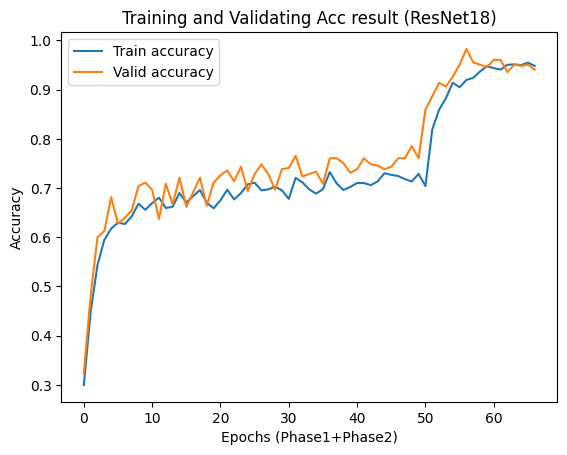

In [35]:
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.xlabel('Epochs (Phase1+Phase2)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validating Acc result (ResNet18)')
plt.show()

In [36]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.xlabel('Epochs (Phase1+Phase2)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validating Loss result (ResNet18)')
plt.show()


# Testing model

In [37]:
load_history_path = '/kaggle/working/' + history_path
with open(load_history_path, 'rb') as f:
    trained_history = pickle.load(f)

trained_model = trained_history['best_model']
trained_model.to(device)
trained_model.eval()

num_params = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)
print('Num trainable params (trained_model):', num_params)

Num trainable params (trained_model): 8396806


In [38]:
def evaluate(model, dataloader, device):
    model.eval()
    total_correct = 0

    all_labels = []
    all_preds = []

    wrong_images = []
    wrong_true_labels = []
    wrong_pred_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            x = batch['image'].to(device)
            y = batch['label'].to(device)

            out = model(x)
            preds = out.argmax(1)

            total_correct += (preds == y).sum().item()

            all_labels.extend(y.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

            incorrect_mask = (preds != y)
            if incorrect_mask.any():
                wrong_images.extend(x[incorrect_mask].cpu())
                wrong_true_labels.extend(y[incorrect_mask].cpu().tolist())
                wrong_pred_labels.extend(preds[incorrect_mask].cpu().tolist())

    eval_acc = total_correct / len(dataloader.dataset)
    print(f'Dự đoán đúng {total_correct}/{len(dataloader.dataset)} ==> eval_acc = {eval_acc:.4f}')

    return wrong_images, wrong_true_labels, wrong_pred_labels, all_labels, all_preds, eval_acc

In [39]:
wrong_images, wrong_true_labels, wrong_pred_labels, \
test_labels, test_predicts, test_acc = evaluate(trained_model, test_loader, device)


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Dự đoán đúng 398/405 ==> eval_acc = 0.9827


In [40]:
print('test_acc:', test_acc)

test_acc: 0.9827160493827161


In [41]:
def plot_wrong_predictions(test_images, test_labels, test_predicts, max_images=25):
    wrong_indices = [i for i, (t, p) in enumerate(zip(test_labels, test_predicts)) if t != p]
    print(f"Tổng số ảnh sai: {len(wrong_indices)}")

    wrong_indices = wrong_indices[:max_images]

    if len(wrong_indices) == 0:
        print("Không có ảnh sai để vẽ.")
        return

    n_cols = 5
    n_rows = int(np.ceil(len(wrong_indices) / n_cols))

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i, idx in enumerate(wrong_indices):
        image = test_images[idx]
        label = test_labels[idx]
        predict = test_predicts[idx]

        img = image.permute(1, 2, 0).numpy()
        img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img = np.clip(img, 0, 1)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"T:{label}, P:{predict}", fontsize=10)

    plt.tight_layout()
    plt.show()

Tổng số ảnh sai: 7


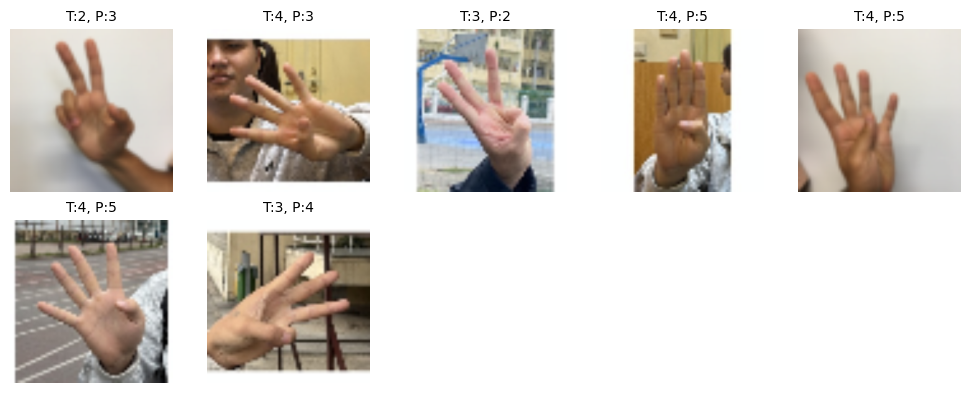

In [42]:
plot_wrong_predictions(wrong_images, wrong_true_labels, wrong_pred_labels, max_images=25)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_and_report(true_labels, pred_labels, class_names=None, normalize=False):
    if class_names is None:
        class_names = [str(i) for i in sorted(set(true_labels) | set(pred_labels))]

    cm = confusion_matrix(true_labels, pred_labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', annot_kws={'size': 14})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('ResNet18 Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

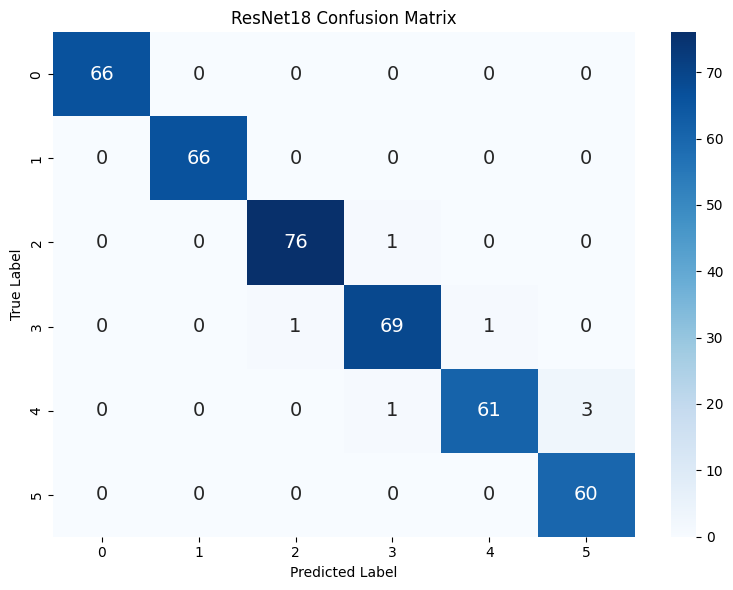


Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        66
           1     1.0000    1.0000    1.0000        66
           2     0.9870    0.9870    0.9870        77
           3     0.9718    0.9718    0.9718        71
           4     0.9839    0.9385    0.9606        65
           5     0.9524    1.0000    0.9756        60

    accuracy                         0.9827       405
   macro avg     0.9825    0.9829    0.9825       405
weighted avg     0.9829    0.9827    0.9827       405



In [44]:
plot_confusion_and_report(test_labels, test_predicts)